# Mapping query data to Fetal Immune reference with scArches

In this notebook, we demonstrate how to use scVI models trained on our fetal immune atlas for query-to-reference mapping of external datasets, making use of the amazing [`scvi-tools`](https://scvi-tools.org/). 

<div class="alert alert-info">

**Note:** this analysis takes much less with GPU!

</div>

### Getting started

We made a conda environment to reproduce this analysis. We need a specific version of scvi-tools, otherwise unexpected errors and inconsistencies with `pytorch` might come up.

In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random
import scipy
import anndata

Global seed set to 0


Set up use of GPU

In [2]:
import torch
device = torch.device("cuda")

### Load query dataset
In this tutorial we use as query scRNA-seq data from the fetal gut generated by [Elmentaite et al. 2020](https://www.sciencedirect.com/science/article/pii/S1534580720308868). 

In [3]:
!wget https://cellgeni.cog.sanger.ac.uk/gutcellatlas/fetal_RAWCOUNTS_cellxgene.h5ad

--2022-01-12 14:56:43--  https://cellgeni.cog.sanger.ac.uk/gutcellatlas/fetal_RAWCOUNTS_cellxgene.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 172.27.51.2, 172.27.51.131, 172.27.51.1, ...
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|172.27.51.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533655305 (1.4G) [application/x-hdf]
Saving to: ‘fetal_RAWCOUNTS_cellxgene.h5ad’

fetal_RAWCOUNTS_cel 100%[===================>]   1.43G  43.1MB/s    in 27s     

2022-01-12 14:57:09 (54.7 MB/s) - ‘fetal_RAWCOUNTS_cellxgene.h5ad’ saved [1533655305/1533655305]



We load the anndata object and subset to the immune cells, to speed up this tutorial. 

In [3]:
query_adata = sc.read_h5ad('./fetal_RAWCOUNTS_cellxgene.h5ad')

In [4]:
query_adata = query_adata[query_adata.obs.cell_type_group == 'immune'].copy()

Before mapping to the fetal immune reference model, we need to check a few things: (A) the model takes in input raw gene counts, so we check that data in `query_adata.X` is not normalized, and (B) the saved models use EnsemblID as variable names, so we need to make sure that `query_adata.var_names` correspond to IDs (rather than gene names).

In [5]:
def _verify_counts(adata):
    return(all([not (i%1) for i in adata.X[0,:].toarray()[0]]))

if not _verify_counts(query_adata):
    raise ValueError('`query_adata.X` does not contain raw counts.')
if not query_adata.var_names.str.startswith("ENS").all():
    raise ValueError('`query_adata.var_names` are not Ensembl geneIDs. Please convert')


ValueError: `query_adata.var_names` are not Ensembl geneIDs. Please convert

In [6]:
## Change var_names to ensemblIDs
query_adata.var['gene_names'] = query_adata.var_names.values.copy()
query_adata.var_names = query_adata.var['gene_ids'].values

### Load trained scVI model

We download the scVI model trained on all immune cells in the fetal immune atlas. Other models trained on lineage subsets (e.g. myeloid cells, NK/T cells) are also available.

In [11]:
!wget https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/scVI_models/scvi_HSC_IMMUNE_model.tar.gz

--2022-01-12 15:01:11--  https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/scVI_models/scvi_HSC_IMMUNE_model.tar.gz
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 172.27.51.129, 172.27.51.3, 172.27.51.131, ...
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|172.27.51.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20084377 (19M) [application/gzip]
Saving to: ‘scvi_HSC_IMMUNE_model.tar.gz’

scvi_HSC_IMMUNE_mod 100%[===================>]  19.15M   101MB/s    in 0.2s    

2022-01-12 15:01:12 (101 MB/s) - ‘scvi_HSC_IMMUNE_model.tar.gz’ saved [20084377/20084377]



In [12]:
!tar -xf scvi_HSC_IMMUNE_model.tar.gz

In [7]:
model_dir = './scvi_HSC_IMMUNE_model/'

### Map query data to fetal immune reference

Now we are ready to map the query to the reference.

We first need to define the column in `query_adata.obs` that defines the technical batches from which cells come, and rename it to match the ID used during reference training (`bbk`). For simplicity, here we assume all cells come from the same technical batch.

In [8]:
query_adata.obs["bbk"] = 'fetal_gut'

Next, we need to handle missing genes in the query. These reference models were trained on 7500 highly variable genes in the reference dataset and excluding cell cycle genes and TCR/BCR genes. We need to make sure that the majority of the genes used for training are profiled in the query dataset.

In [9]:
var_names_model = pd.read_csv(model_dir + "var_names.csv", header=None)[0].values
is_in_query_var = pd.Series(var_names_model).isin(query_adata.var_names)
n_genes = len(var_names_model[~is_in_query_var])
print("% or genes missing from query: {p}%".format(p=np.round((n_genes/len(var_names_model))*100,2)))

% or genes missing from query: 1.36%


We replace missing reference genes in the query with zeros, following the workflow proposed by [Lotfollahi et al.](https://www.nature.com/articles/s41587-021-01001-7):

> [...] integration performance was robust when 10% (of 2,000 genes) were missing from query data.

In [10]:
## Zero-filling
empty_X = np.zeros(shape=[ query_adata.n_obs, n_genes])
empty_query_adata = anndata.AnnData(X=empty_X, obs=query_adata.obs)
empty_query_adata.var_names = var_names_model[~is_in_query_var]
empty_query_adata.var_names.names = ["index"]
query_adata_filled = anndata.concat([query_adata, empty_query_adata], axis=1)
query_adata_filled = query_adata_filled[:,var_names_model].copy()
query_adata_filled.obs = query_adata.obs.copy()

Now we are all set to train our model on the query data. We follow the worflow described in the [reference mapping tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html) of `scvi-tools`.

In [11]:
## Load new model with the query data
vae_q = scvi.model.SCVI.load_query_data(
    query_adata_filled,
    model_dir,
    inplace_subset_query_vars=True
)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 1967 cells, 7500 vars, 34 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/jovyan/my-conda-envs/fetal-immune-scarches-env/lib/python3.7/site-packages/scvi/model/base/_archesmixin.py:96: UserWarning: Query integration should be performed using models trained with version >= 0.8
  "Query integration should be performed using models trained with version >= 0.8"
/home/jovyan/my-conda-envs/fetal-immune-scarches-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [12]:
## Train
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 2/200:   0%|          | 1/200 [00:07<25:33,  7.71s/it, loss=1.56e+03, v_num=1]

/home/jovyan/my-conda-envs/fetal-immune-scarches-env/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


Now we can extract the latent representation learnt for the query dataset

In [14]:
query_adata_filled.obsm["X_scvi"] = vae_q.get_latent_representation()

In [21]:
sc.pp.neighbors(query_adata_filled, use_rep="X_scvi")
sc.tl.leiden(query_adata_filled)
sc.tl.umap(query_adata_filled)

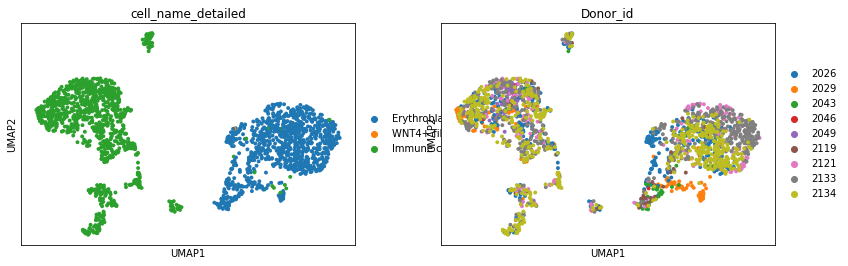

In [25]:
sc.pl.umap(query_adata_filled, color=['cell_name_detailed','Donor_id'])

### Visualize with fetal immune reference data

To jointly analyse the mapped data with the reference data, we need to download the full dataset (this can take a while).

In [ ]:
!wget https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad

--2022-01-12 16:34:15--  https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 172.27.51.2, 172.27.51.1, 172.27.51.130, ...
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|172.27.51.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11174824039 (10G) [application/octet-stream]
Saving to: ‘PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad’

.A01.v01.raw_count.  42%[=======>            ]   4.38G  52.3MB/s    eta 2m 17s 